# Part 4 solutions (don't peek!)

In [1]:
# NumPy
import numpy as np

# JAX
import jax
import jax.numpy as jnp

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

# Numba
import numba as nb

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt

# JAX solution

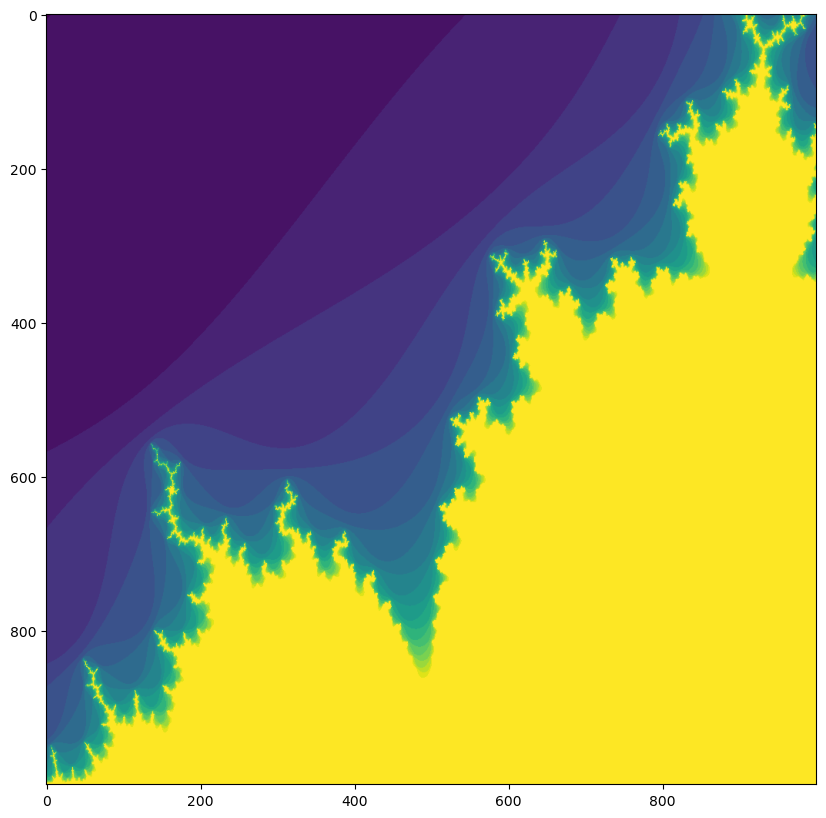

In [2]:
@jax.jit
def mandelbrot_jax_kernel(x, y):
    c = x + y*1j
    fractal = jnp.full(c.shape, 20, dtype=jnp.int8)
    z = c
    for i in range(20):
        z = z**2 + c
        diverged = jnp.absolute(z) > 2
        diverging_now = diverged & (fractal == 20)
        fractal = jnp.where(diverging_now, i, fractal)  # <--- use a ternary operator ("where") instead of masked-assignment
    return fractal


def mandelbrot_jax(height, width):
    y, x = jnp.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    return mandelbrot_jax_kernel(x, y)


fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(mandelbrot_jax(1000, 1000))

In [3]:
%%timeit -n 10 -r 1

mandelbrot_jax(1000, 1000).block_until_ready()

3.76 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


# Numba solution

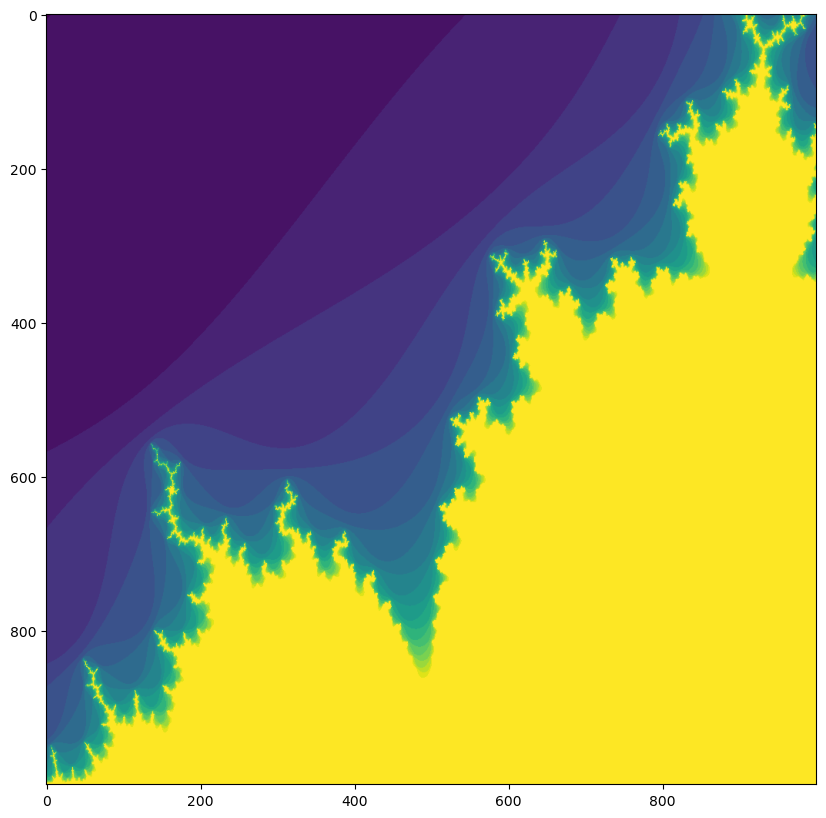

In [4]:
@nb.njit(fastmath=True)  # <--- like -ffast-math in the C++ compiler
def mandelbrot_numba_kernel(height, width, x, y):
    c = x + y*1j
    fractal = np.full(c.shape, 20, dtype=np.int8)
    for h in range(height):
        for w in range(width):
            z = c[h, w]
            for i in range(20):
                z = z**2 + c[h, w]
                if z.real**2 + z.imag**2 > 4:  # <--- only difference from pure Python
                    fractal[h, w] = i
                    break
    return fractal

def mandelbrot_numba(height, width):
    y, x = np.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    return mandelbrot_numba_kernel(height, width, x, y)


fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(mandelbrot_numba(1000, 1000))

In [5]:
%%timeit -n 10 -r 1

mandelbrot_numba(1000, 1000)

14.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


### Wonderful write-up by Jim Pivarski on various implementations and their performance:

- Original JAX issue: [Why is JAX so fast?](https://github.com/jax-ml/jax/discussions/11078)
- Notebook: https://gist.github.com/jpivarski/da343abd8024834ee8c5aaba691aafc7


### Results:

![image](https://gist.githubusercontent.com/jpivarski/da343abd8024834ee8c5aaba691aafc7/raw/e05e32077c54eeb63d05734b51097d6d7437f1d6/plot-mandelbrot-on-all-accelerators.svg)